In [5]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

import joblib 
import re
import string
import unicodedata
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [6]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [7]:
# Swap between these
# pipeline_lr.joblib
# pipeline_mlp.joblib
# pipeline_rf.joblib
# pipeline_xgb.joblib

stack = joblib.load('../../Models/70-30 Test/pipeline_mlp.joblib')

training = pd.read_csv('../../Data Splits/test_data.csv')

training_x = training['article']

training_y = training['label']

x = stack.named_steps['vectorizer'].transform(training_x)
print(x.shape)



(301, 31495)


Metrics for MNB:
Accuracy: 0.8438538205980066
Precision: 0.7653061224489796
Recall: 0.9933774834437086
F1 Score: 0.8645533141210374
AUC: 0.9803090507726269
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.82       150
           1       0.77      0.99      0.86       151

    accuracy                           0.84       301
   macro avg       0.88      0.84      0.84       301
weighted avg       0.88      0.84      0.84       301



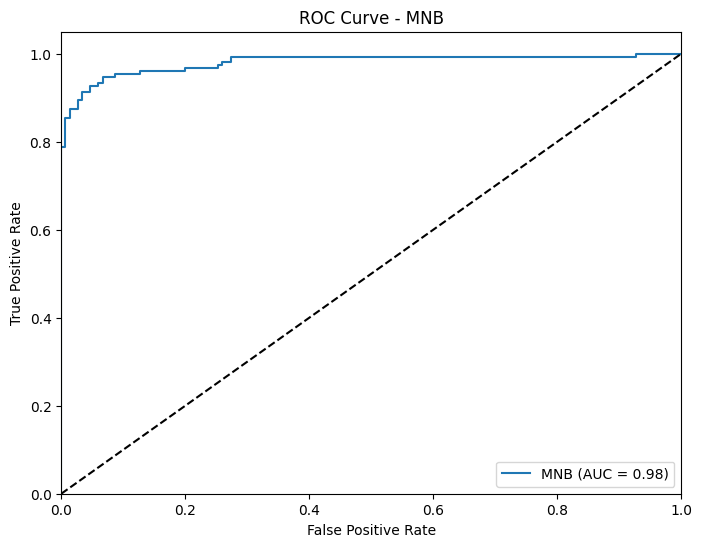

Metrics for LR:
Accuracy: 0.9501661129568106
Precision: 0.9788732394366197
Recall: 0.9205298013245033
F1 Score: 0.9488054607508533
AUC: 0.9860927152317881
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       150
           1       0.98      0.92      0.95       151

    accuracy                           0.95       301
   macro avg       0.95      0.95      0.95       301
weighted avg       0.95      0.95      0.95       301



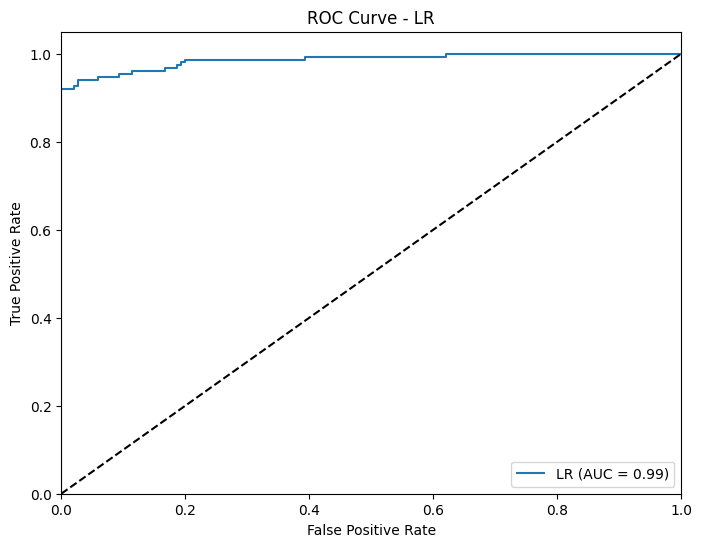

Metrics for RF:
Accuracy: 0.9269102990033222
Precision: 0.9271523178807947
Recall: 0.9271523178807947
F1 Score: 0.9271523178807947
AUC: 0.9811920529801325
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       150
           1       0.93      0.93      0.93       151

    accuracy                           0.93       301
   macro avg       0.93      0.93      0.93       301
weighted avg       0.93      0.93      0.93       301



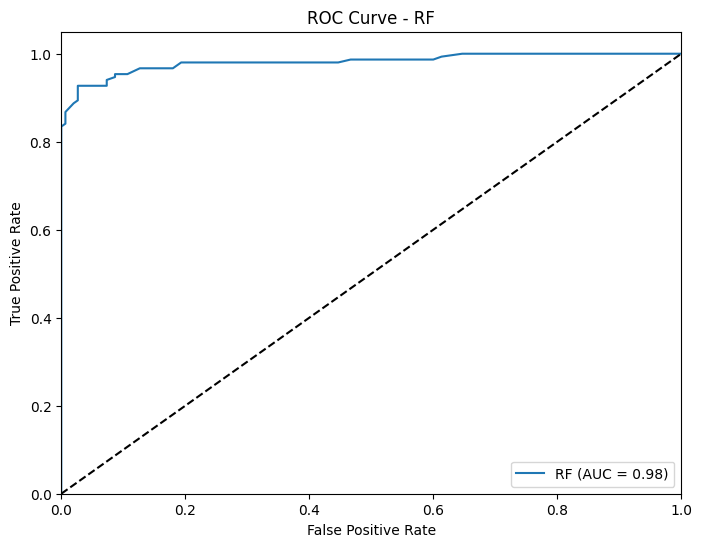

Metrics for KNN:
Accuracy: 0.8803986710963455
Precision: 0.8285714285714286
Recall: 0.9602649006622517
F1 Score: 0.8895705521472392
AUC: 0.9455629139072848
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       150
           1       0.83      0.96      0.89       151

    accuracy                           0.88       301
   macro avg       0.89      0.88      0.88       301
weighted avg       0.89      0.88      0.88       301



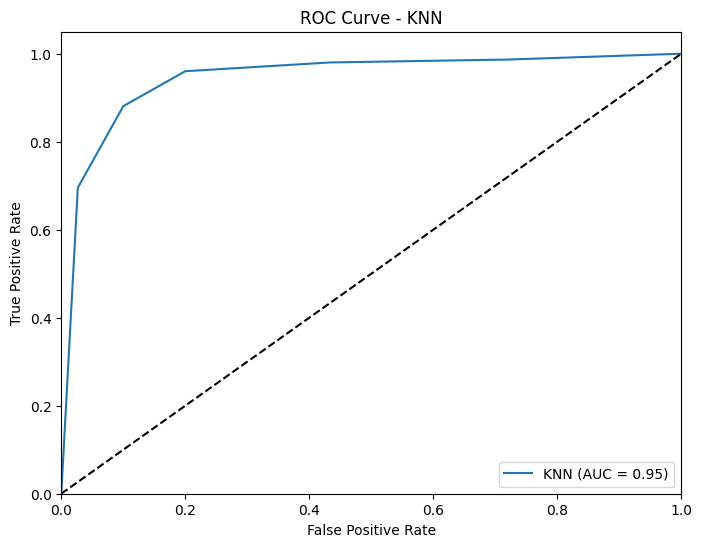

Metrics for SVM:
Accuracy: 0.9568106312292359
Precision: 0.9859154929577465
Recall: 0.9271523178807947
F1 Score: 0.9556313993174061
AUC: 0.9876379690949227
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       150
           1       0.99      0.93      0.96       151

    accuracy                           0.96       301
   macro avg       0.96      0.96      0.96       301
weighted avg       0.96      0.96      0.96       301



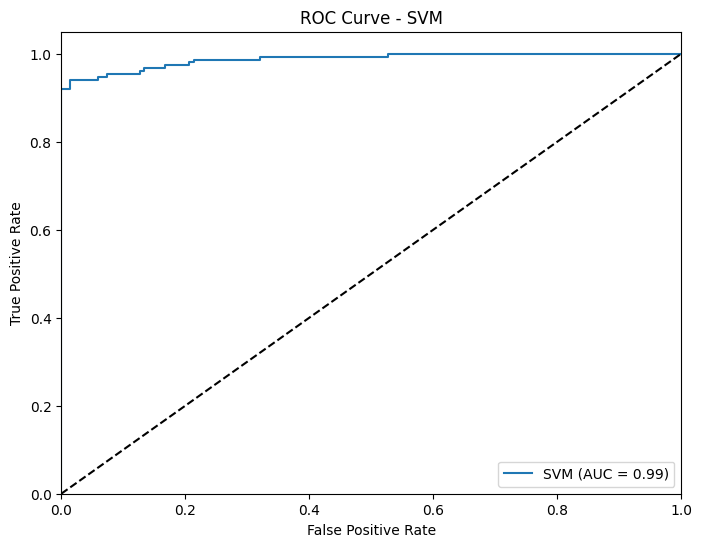

Metrics for Stacking Model:
Accuracy: 0.9534883720930233
Precision: 0.959731543624161
Recall: 0.9470198675496688
F1 Score: 0.9533333333333334
AUC: 0.9891832229580575
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       150
           1       0.96      0.95      0.95       151

    accuracy                           0.95       301
   macro avg       0.95      0.95      0.95       301
weighted avg       0.95      0.95      0.95       301



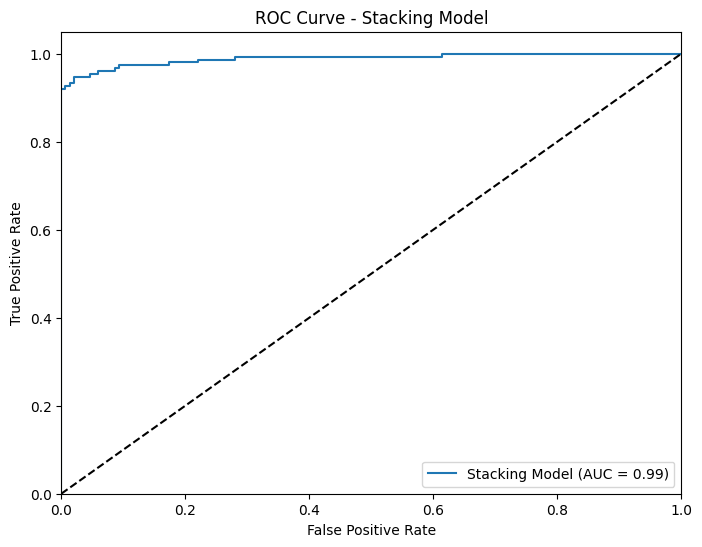

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.843854  0.765306  0.993377  0.864553  0.980309
LR              0.950166  0.978873   0.92053  0.948805  0.986093
RF               0.92691  0.927152  0.927152  0.927152  0.981192
KNN             0.880399  0.828571  0.960265  0.889571  0.945563
SVM             0.956811  0.985915  0.927152  0.955631  0.987638
Stacking Model  0.953488  0.959732   0.94702  0.953333  0.989183


In [8]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

vectorized_text = stack.named_steps['vectorizer'].transform(training_x)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(training_y, y_pred)
    precision = precision_score(training_y, y_pred)
    recall = recall_score(training_y, y_pred)
    f1 = f1_score(training_y, y_pred)
    auc = roc_auc_score(training_y, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(training_y, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(training_y, y_prob)
    roc_auc = roc_auc_score(training_y, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()


# Evaluate stacking model
stack_y_pred = stack.predict(training_x)
stack_y_prob = stack.predict_proba(training_x)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(training_y, stack_y_pred)
stack_precision = precision_score(training_y, stack_y_pred)
stack_recall = recall_score(training_y, stack_y_pred)
stack_f1 = f1_score(training_y, stack_y_pred)
stack_auc = roc_auc_score(training_y, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(training_y, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(training_y, stack_y_prob)
stack_roc_auc = roc_auc_score(training_y, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)